<a href="https://colab.research.google.com/github/amien1410/kaggle-projects/blob/main/Netflix_Data_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install Kaggle Modules to download the dataset
!pip install kaggle

# Load Kaggle user authorization key
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

# Download the dataset, get the user and dataset name from the url "https://www.kaggle.com/datasets/shivamb/netflix-shows"
!kaggle datasets download -d shivamb/netflix-shows

# Unzip the dataset
!unzip -q "/content/netflix-shows"

# Download Netflix icon
!wget https://www.pngarts.com/files/1/Netflix-Logo-PNG-Transparent-Image.png -O netflix-icon-new.png

Dataset URL: https://www.kaggle.com/datasets/shivamb/netflix-shows
License(s): CC0-1.0
  0% 0.00/1.34M [00:00<?, ?B/s]
100% 1.34M/1.34M [00:00<00:00, 21.4MB/s]


In [2]:
#@title Importing libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import plotly as py
import plotly.graph_objs as go
import os
py.offline.init_notebook_mode(connected = True)
import datetime as dt
import missingno as msno
plt.rcParams['figure.dpi'] = 140

In [3]:
# Load the dataset into a dataframe
df = pd.read_csv('/content/netflix_titles.csv')
df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


In [4]:
# Check missing data percentage
for i in df.columns:
    null_rate = df[i].isna().sum() / len(df) * 100
    if null_rate > 0 :
        print("{} null rate: {}%".format(i,round(null_rate,2)))

director null rate: 29.91%
cast null rate: 9.37%
country null rate: 9.44%
date_added null rate: 0.11%
rating null rate: 0.05%
duration null rate: 0.03%


In [5]:
#@title Data Cleaning

# replace blank countries with the mode (most common) country
df['country'] = df['country'].fillna(df['country'].mode()[0])


df['cast'].replace(np.nan, 'No Data',inplace  = True)
df['director'].replace(np.nan, 'No Data',inplace  = True)

# Drops
df.dropna(inplace=True)

# Drop Duplicates
df.drop_duplicates(inplace= True)

In [6]:
# Check null data
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [7]:
# Check dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8790 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   cast          8790 non-null   object
 5   country       8790 non-null   object
 6   date_added    8790 non-null   object
 7   release_year  8790 non-null   int64 
 8   rating        8790 non-null   object
 9   duration      8790 non-null   object
 10  listed_in     8790 non-null   object
 11  description   8790 non-null   object
dtypes: int64(1), object(11)
memory usage: 892.7+ KB


In [8]:
# fix the date_added incorrect format, Convert the 'date_added' column to datetime format
df['date_added'] = pd.to_datetime(df['date_added'], infer_datetime_format=True, errors='coerce')

# Extract month, month name, and year
df['month_added'] = df['date_added'].dt.month
df['month_name_added'] = df['date_added'].dt.month_name()
df['year_added'] = df['date_added'].dt.year

df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,month_added,month_name_added,year_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Data,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",9.0,September,2021.0
1,s2,TV Show,Blood & Water,No Data,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",9.0,September,2021.0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,9.0,September,2021.0


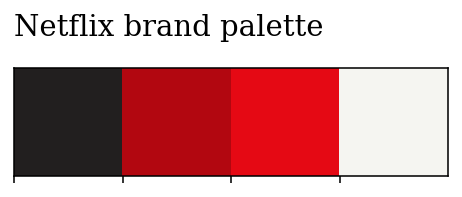

In [9]:
#@title Data Visualization

# Set Netflix color pallete, reference 'https://brand.netflix.com/en/assets/brand-symbol/'
# Palette
sns.palplot(['#221f1f', '#b20710', '#e50914','#f5f5f1'])

plt.title("Netflix brand palette ",loc='left',fontfamily='serif',fontsize=15,y=1.2)
plt.show()

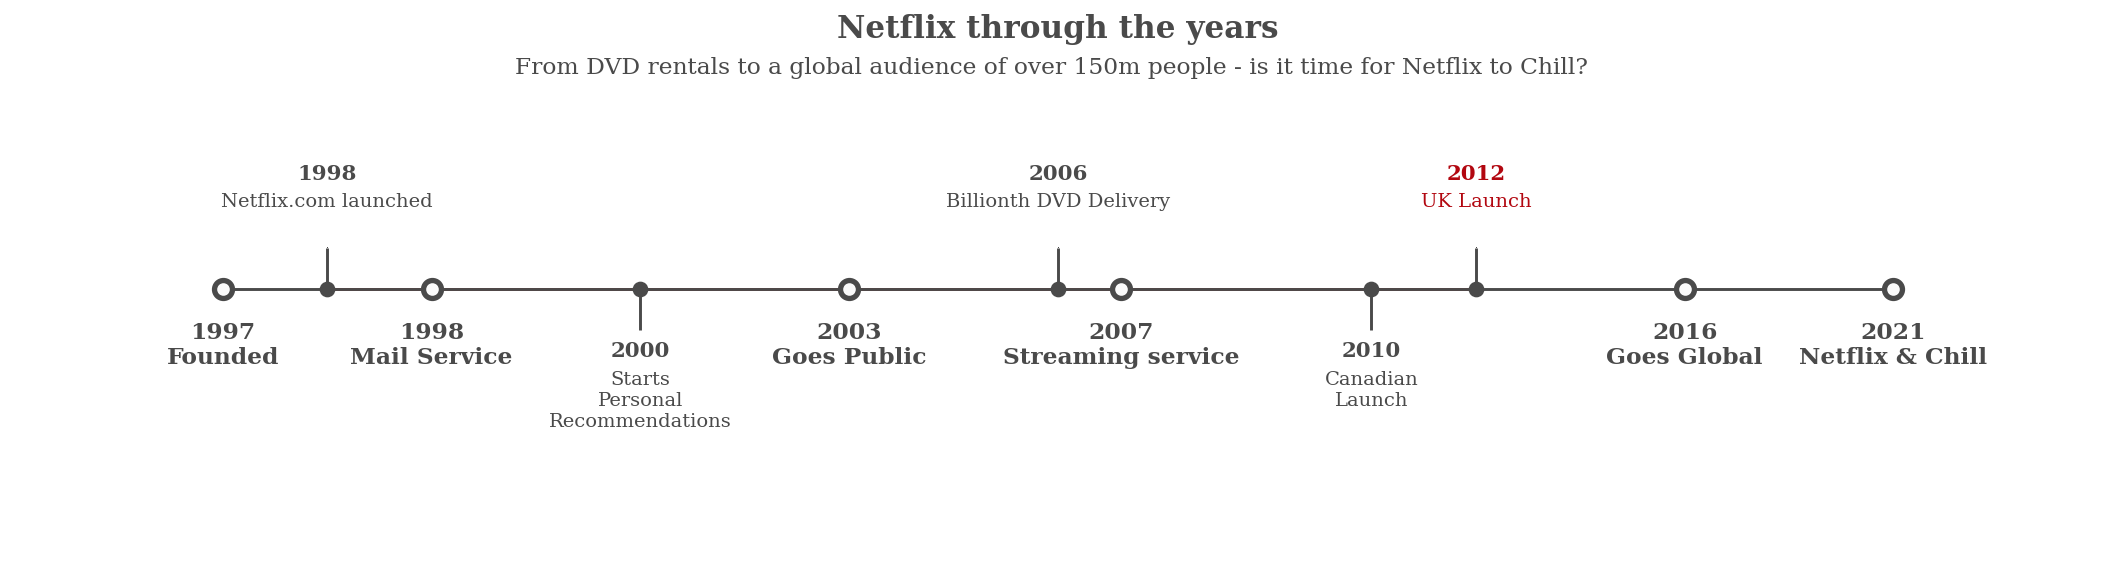

In [10]:
#@title Netflix history timeline
from datetime import datetime

## these go on the numbers below
tl_dates = [
    "1997\nFounded",
    "1998\nMail Service",
    "2003\nGoes Public",
    "2007\nStreaming service",
    "2016\nGoes Global",
    "2021\nNetflix & Chill"
]

tl_x = [1, 2, 4, 5.3, 8,9]

## these go on the numbers
tl_sub_x = [1.5,3,5,6.5,7]


tl_sub_times = [
    "1998","2000","2006","2010","2012"
]

tl_text = [
    "Netflix.com launched",
    "Starts\nPersonal\nRecommendations","Billionth DVD Delivery","Canadian\nLaunch","UK Launch"]



# Set figure & Axes
fig, ax = plt.subplots(figsize=(15, 4), constrained_layout=True)
ax.set_ylim(-2, 1.75)
ax.set_xlim(0, 10)


# Timeline : line
ax.axhline(0, xmin=0.1, xmax=0.9, c='#4a4a4a', zorder=1)


# Timeline : Date Points
ax.scatter(tl_x, np.zeros(len(tl_x)), s=120, c='#4a4a4a', zorder=2)
ax.scatter(tl_x, np.zeros(len(tl_x)), s=30, c='#fafafa', zorder=3)
# Timeline : Time Points
ax.scatter(tl_sub_x, np.zeros(len(tl_sub_x)), s=50, c='#4a4a4a',zorder=4)

# Date Text
for x, date in zip(tl_x, tl_dates):
    ax.text(x, -0.55, date, ha='center',
            fontfamily='serif', fontweight='bold',
            color='#4a4a4a',fontsize=12)


# Stemplot : vertical line
levels = np.zeros(len(tl_sub_x))
levels[::2] = 0.3
levels[1::2] = -0.3
markerline, stemline, baseline = ax.stem(tl_sub_x, levels, use_line_collection=True)
plt.setp(baseline, zorder=0)
plt.setp(markerline, marker=',', color='#4a4a4a')
plt.setp(stemline, color='#4a4a4a')

# Text
for idx, x, time, txt in zip(range(1, len(tl_sub_x)+1), tl_sub_x, tl_sub_times, tl_text):
    ax.text(x, 1.3*(idx%2)-0.5, time, ha='center',
            fontfamily='serif', fontweight='bold',
            color='#4a4a4a' if idx!=len(tl_sub_x) else '#b20710', fontsize=11)

    ax.text(x, 1.3*(idx%2)-0.6, txt, va='top', ha='center',
        fontfamily='serif',color='#4a4a4a' if idx!=len(tl_sub_x) else '#b20710')



# Spine
for spine in ["left", "top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)

# Ticks
ax.set_xticks([])
ax.set_yticks([])

# Title
ax.set_title("Netflix through the years", fontweight="bold", fontfamily='serif', fontsize=16, color='#4a4a4a')
ax.text(2.4,1.57,"From DVD rentals to a global audience of over 150m people - is it time for Netflix to Chill?", fontfamily='serif', fontsize=12, color='#4a4a4a')

plt.show()

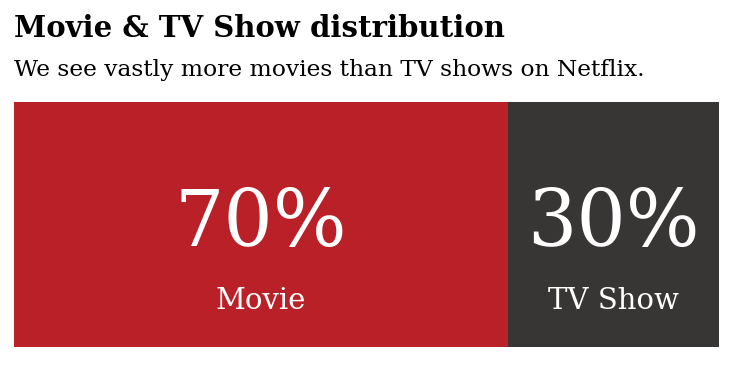

In [11]:
#@title Exploring the data

# Ratio of Movies & TV shows

x=df.groupby(['type'])['type'].count()
y=len(df)
r=((x/y)).round(2)

mf_ratio = pd.DataFrame(r).T

fig, ax = plt.subplots(1,1,figsize=(6.5, 2.5))

ax.barh(mf_ratio.index, mf_ratio['Movie'],
        color='#b20710', alpha=0.9, label='Male')
ax.barh(mf_ratio.index, mf_ratio['TV Show'], left=mf_ratio['Movie'],
        color='#221f1f', alpha=0.9, label='Female')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_yticklabels(mf_ratio.index, fontfamily='serif', fontsize=11)


# movie percentage
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Movie'][i]*100)}%",
                   xy=(mf_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Movie",
                   xy=(mf_ratio['Movie'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')


for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['TV Show'][i]*100)}%",
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')
    ax.annotate("TV Show",
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')






# Title & Subtitle
fig.text(0.125,1.03,'Movie & TV Show distribution', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.92,'We see vastly more movies than TV shows on Netflix.',fontfamily='serif',fontsize=12)

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)



#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

# Removing legend due to labelled plot
ax.legend().set_visible(False)
plt.show()

In [12]:
# Quick feature engineering

# Helper column for various plots
df['count'] = 1

# Many productions have several countries listed - this will skew our results , we'll grab the first one mentioned

# Lets retrieve just the first country
df['first_country'] = df['country'].apply(lambda x: x.split(",")[0])
df['first_country'].head()

# Rating ages from this notebook: https://www.kaggle.com/andreshg/eda-beginner-to-expert-plotly (thank you!)

ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

# Genre

df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(','))

# Reducing name length

df['first_country'].replace('United States', 'USA', inplace=True)
df['first_country'].replace('United Kingdom', 'UK',inplace=True)
df['first_country'].replace('South Korea', 'S. Korea',inplace=True)

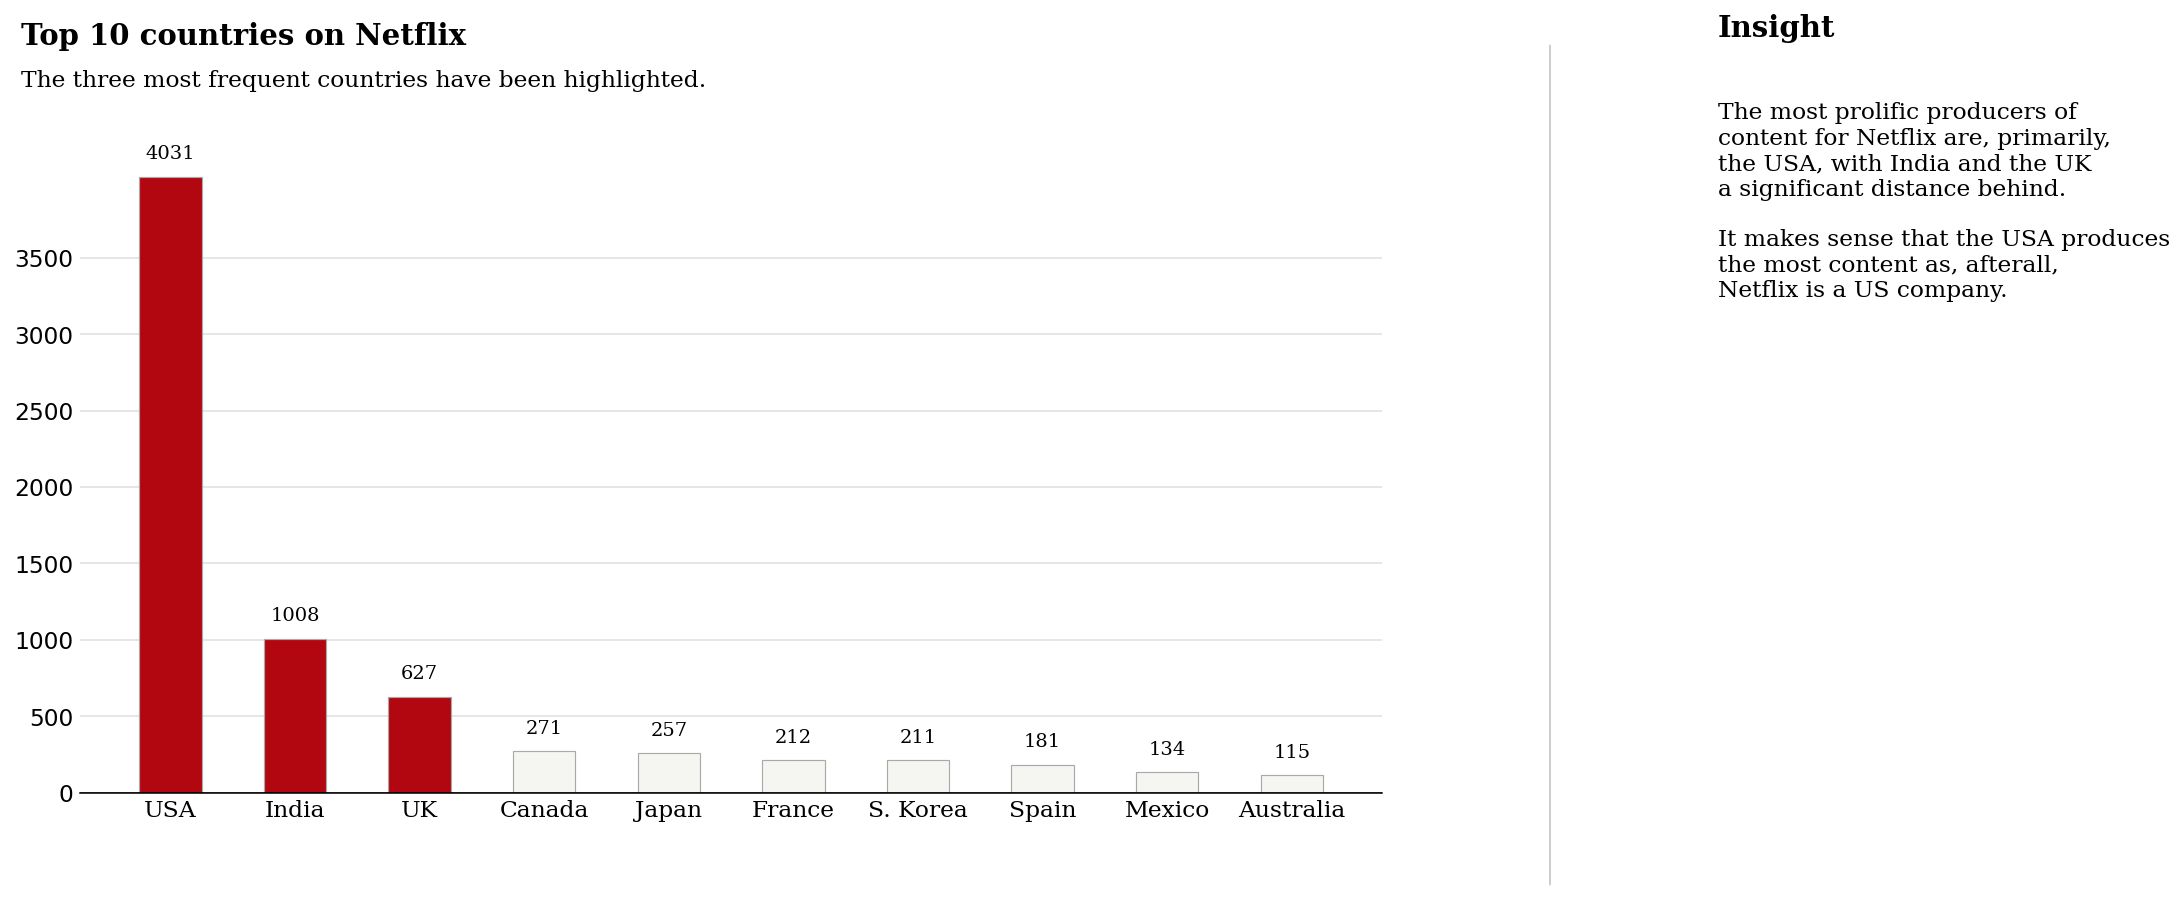

In [13]:
data = df.groupby('first_country')['count'].sum().sort_values(ascending=False)[:10]

# Plot

color_map = ['#f5f5f1' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  '#b20710' # color highlight

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(data.index, data, width=0.5,
       edgecolor='darkgray',
       linewidth=0.6,color=color_map)

#annotations
for i in data.index:
    ax.annotate(f"{data[i]}",
                   xy=(i, data[i] + 150), #i like to change this to roughly 5% of the highest cat
                   va = 'center', ha='center',fontweight='light', fontfamily='serif')



# Remove border from plot

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Tick labels

ax.set_xticklabels(data.index, fontfamily='serif', rotation=0)

# Title and sub-title

fig.text(0.09, 1, 'Top 10 countries on Netflix', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.95, 'The three most frequent countries have been highlighted.', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(1.1, 1.01, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.1, 0.67, '''
The most prolific producers of
content for Netflix are, primarily,
the USA, with India and the UK
a significant distance behind.

It makes sense that the USA produces
the most content as, afterall,
Netflix is a US company.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')

ax.grid(axis='y', linestyle='-', alpha=0.4)

grid_y_ticks = np.arange(0, 4000, 500) # y ticks, min, max, then step
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

#Axis labels

#plt.xlabel("Country", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)
#plt.ylabel("Count", fontsize=12, fontweight='light', fontfamily='serif')
 #plt.legend(loc='upper right')

# thicken the bottom line if you want to
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

ax.tick_params(axis='both', which='major', labelsize=12)


import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

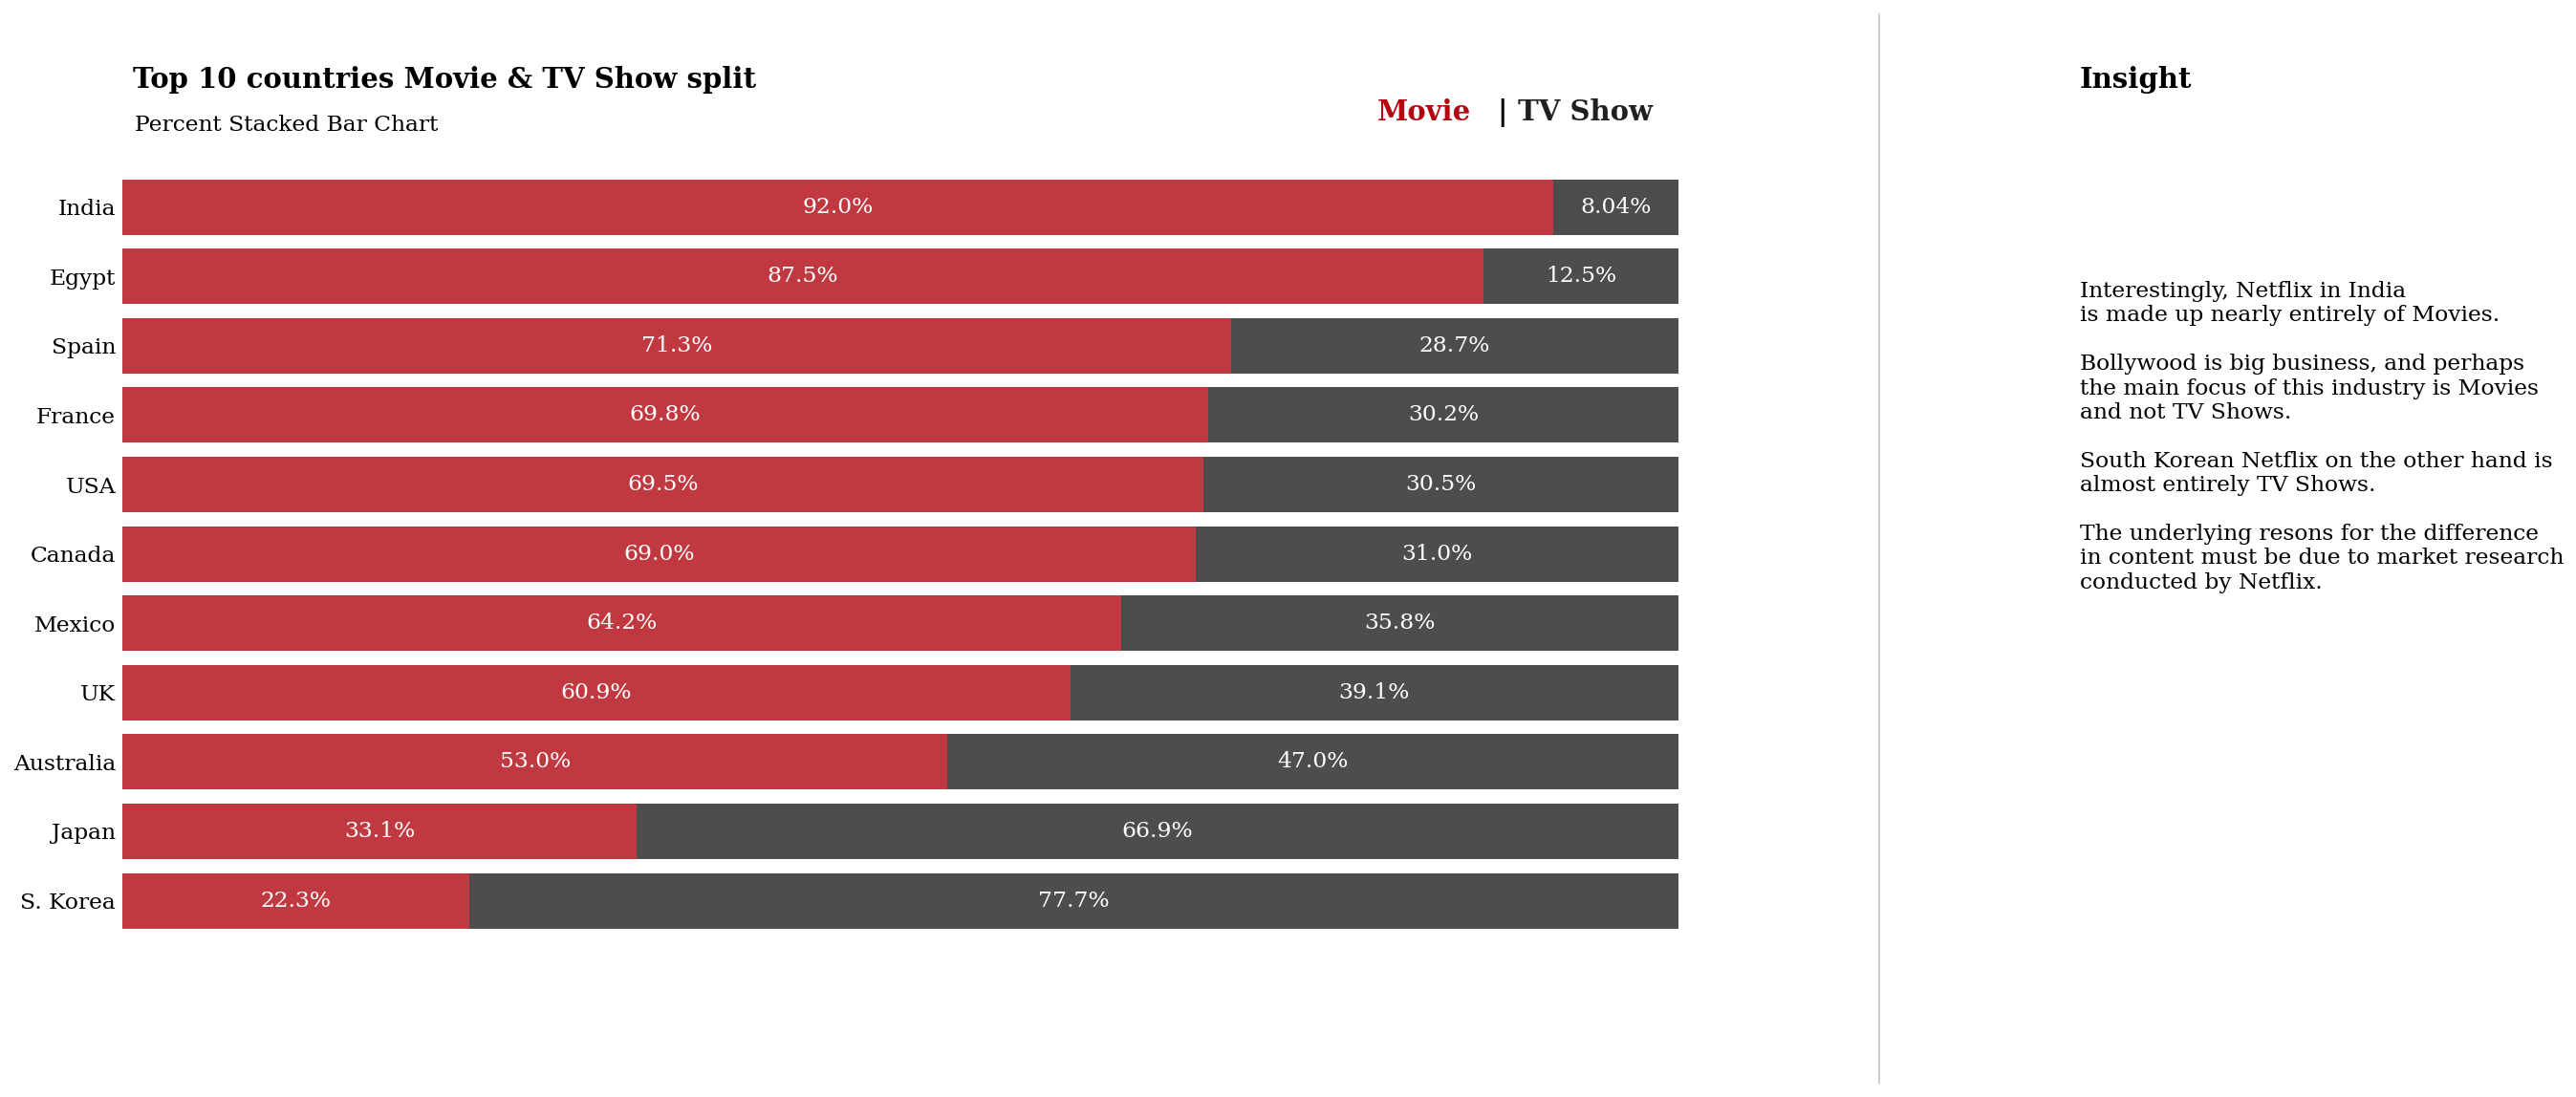

In [14]:
# TV Shows and Movies varies by country
country_order = df['first_country'].value_counts()[:11].index
data_q2q3 = df[['type', 'first_country']].groupby('first_country')['type'].value_counts().unstack().loc[country_order]
data_q2q3['sum'] = data_q2q3.sum(axis=1)
data_q2q3_ratio = (data_q2q3.T / data_q2q3['sum']).T[['Movie', 'TV Show']].sort_values(by='Movie',ascending=False)[::-1]




###
fig, ax = plt.subplots(1,1,figsize=(15, 8),)

ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Movie'],
        color='#b20710', alpha=0.8, label='Movie')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['TV Show'], left=data_q2q3_ratio['Movie'],
        color='#221f1f', alpha=0.8, label='TV Show')


ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)

# male percentage
for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['Movie'][i]*100:.3}%",
                   xy=(data_q2q3_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['TV Show'][i]*100:.3}%",
                   xy=(data_q2q3_ratio['Movie'][i]+data_q2q3_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')


fig.text(0.13, 0.93, 'Top 10 countries Movie & TV Show split', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.131, 0.89, 'Percent Stacked Bar Chart', fontsize=12,fontfamily='serif')

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

fig.text(0.75,0.9,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.81,0.9,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.82,0.9,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')


fig.text(1.1, 0.93, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.1, 0.44, '''
Interestingly, Netflix in India
is made up nearly entirely of Movies.

Bollywood is big business, and perhaps
the main focus of this industry is Movies
and not TV Shows.

South Korean Netflix on the other hand is
almost entirely TV Shows.

The underlying resons for the difference
in content must be due to market research
conducted by Netflix.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')



import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])




ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

In [15]:
# Rating distribution
order = pd.DataFrame(df.groupby('rating')['count'].sum().sort_values(ascending=False).reset_index())
rating_order = list(order['rating'])
# print(order)

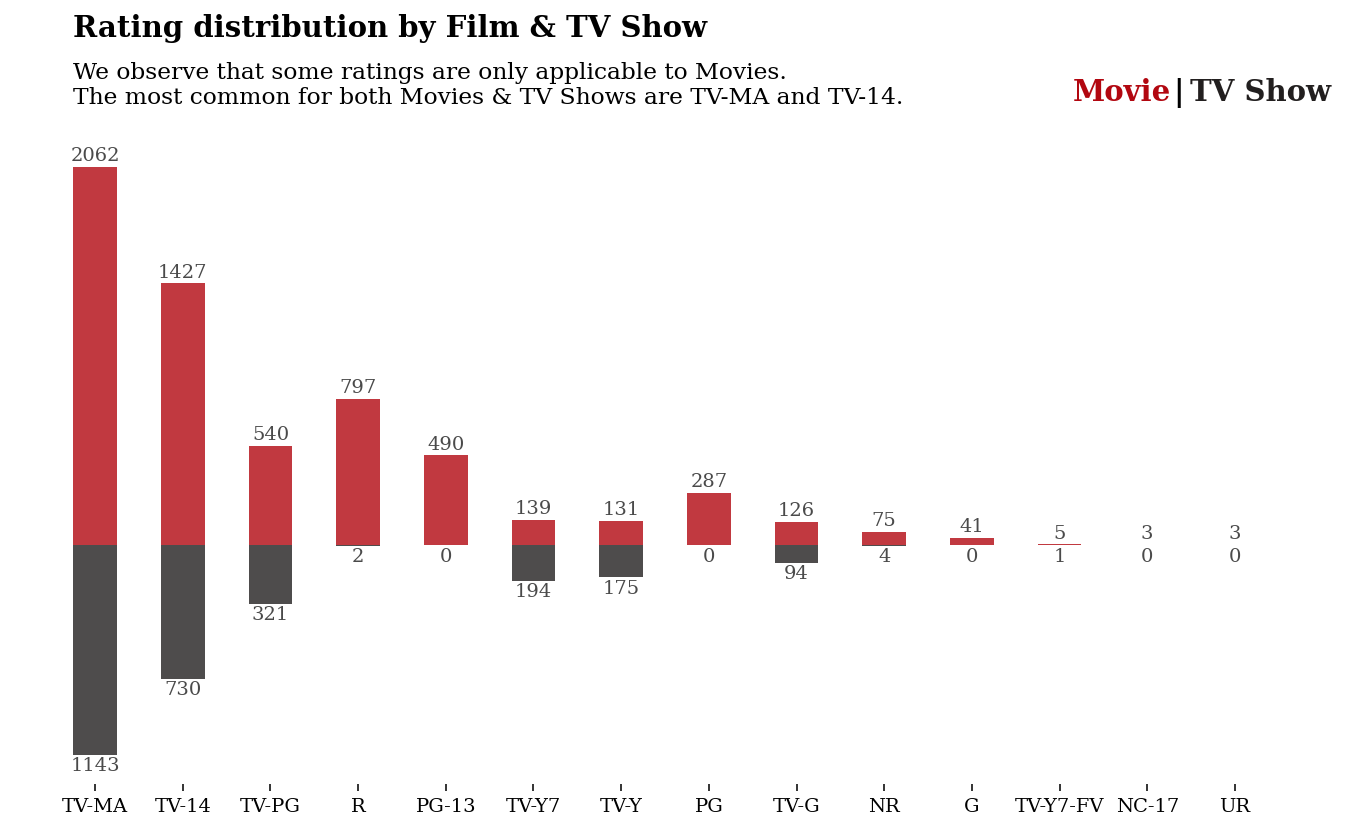

In [16]:
# Visualize the ratings
mf = df.groupby('type')['rating'].value_counts().unstack().sort_index().fillna(0).astype(int)[rating_order]

movie = mf.loc['Movie']
tv = - mf.loc['TV Show']


fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(movie.index, movie, width=0.5, color='#b20710', alpha=0.8, label='Movie')
ax.bar(tv.index, tv, width=0.5, color='#221f1f', alpha=0.8, label='TV Show')
#ax.set_ylim(-35, 50)

# Annotations
for i in tv.index:
    ax.annotate(f"{-tv[i]}",
                   xy=(i, tv[i] - 60),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')

for i in movie.index:
    ax.annotate(f"{movie[i]}",
                   xy=(i, movie[i] + 60),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')



for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

ax.set_xticklabels(mf.columns, fontfamily='serif')
ax.set_yticks([])

ax.legend().set_visible(False)
fig.text(0.16, 1, 'Rating distribution by Film & TV Show', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.16, 0.89,
'''We observe that some ratings are only applicable to Movies.
The most common for both Movies & TV Shows are TV-MA and TV-14.
'''

, fontsize=12, fontweight='light', fontfamily='serif')


fig.text(0.755,0.924,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.815,0.924,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.825,0.924,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

plt.show()

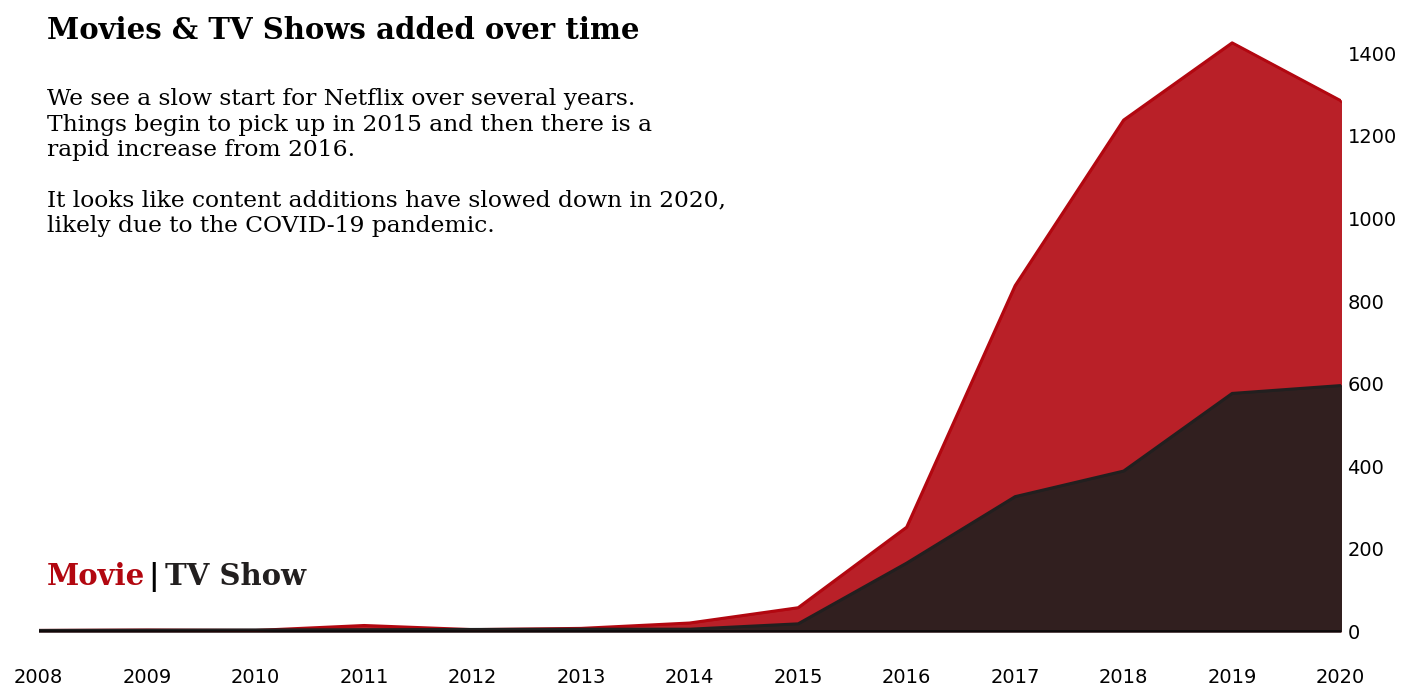

In [17]:
# Movies and TV-Shows added over time
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ["#b20710", "#221f1f"]

for i, mtv in enumerate(df['type'].value_counts().index):
    mtv_rel = df[df['type']==mtv]['year_added'].value_counts().sort_index()
    ax.plot(mtv_rel.index, mtv_rel, color=color[i], label=mtv)
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], alpha=0.9)

ax.yaxis.tick_right()

ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

#ax.set_ylim(0, 50)
#ax.legend(loc='upper left')
for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.grid(False)

ax.set_xlim(2008,2020)
plt.xticks(np.arange(2008, 2021, 1))

fig.text(0.13, 0.85, 'Movies & TV Shows added over time', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.59,
'''We see a slow start for Netflix over several years.
Things begin to pick up in 2015 and then there is a
rapid increase from 2016.

It looks like content additions have slowed down in 2020,
likely due to the COVID-19 pandemic.
'''

, fontsize=12, fontweight='light', fontfamily='serif')


fig.text(0.13,0.2,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19,0.2,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2,0.2,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

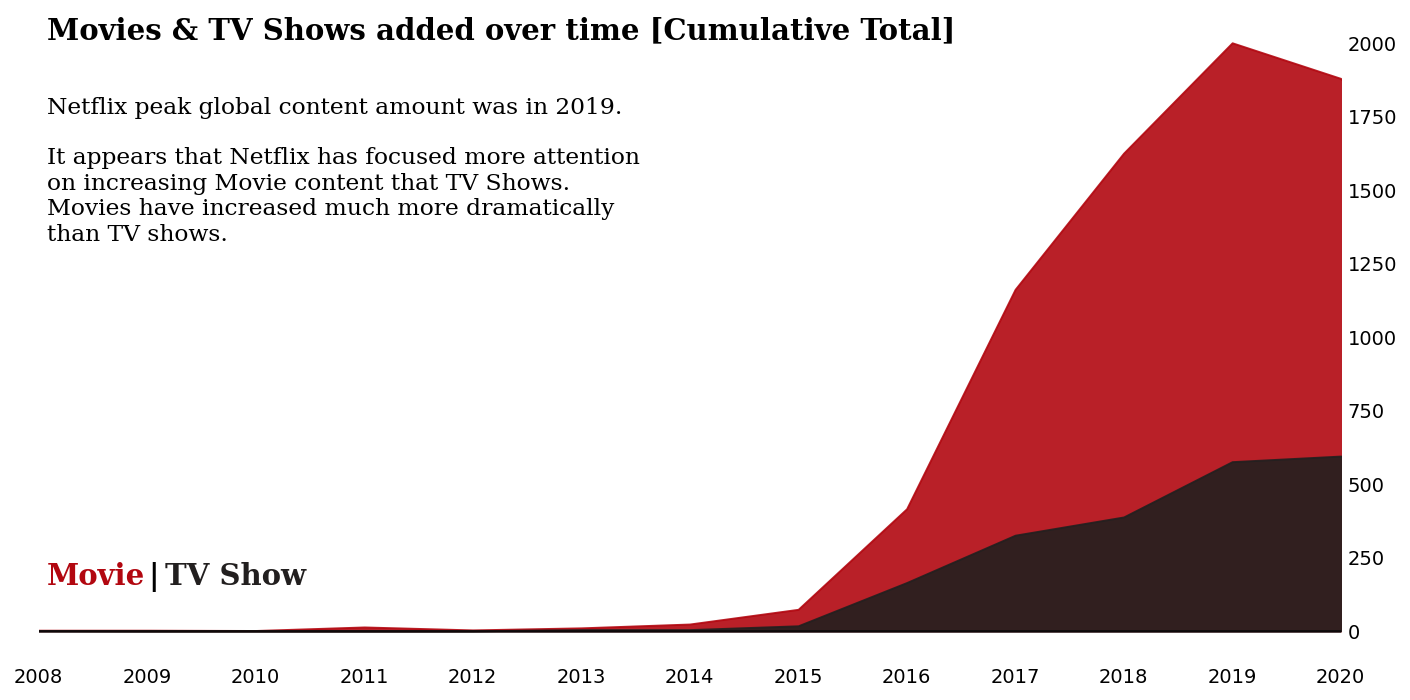

In [18]:
data_sub = df.groupby('type')['year_added'].value_counts().unstack().fillna(0).loc[['TV Show','Movie']].cumsum(axis=0).T

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ["#b20710", "#221f1f"]

for i, mtv in enumerate(df['type'].value_counts().index):
    mtv_rel = data_sub[mtv]
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], label=mtv,alpha=0.9)



ax.yaxis.tick_right()

ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

#ax.set_ylim(0, 50)
#ax.legend(loc='upper left')
for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.grid(False)

ax.set_xlim(2008,2020)
plt.xticks(np.arange(2008, 2021, 1))

fig.text(0.13, 0.85, 'Movies & TV Shows added over time [Cumulative Total]', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.58,
'''Netflix peak global content amount was in 2019.

It appears that Netflix has focused more attention
on increasing Movie content that TV Shows.
Movies have increased much more dramatically
than TV shows.
'''

, fontsize=12, fontweight='light', fontfamily='serif')



fig.text(0.13,0.2,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19,0.2,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2,0.2,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

ax.tick_params(axis=u'both', which=u'both',length=0)


plt.show()

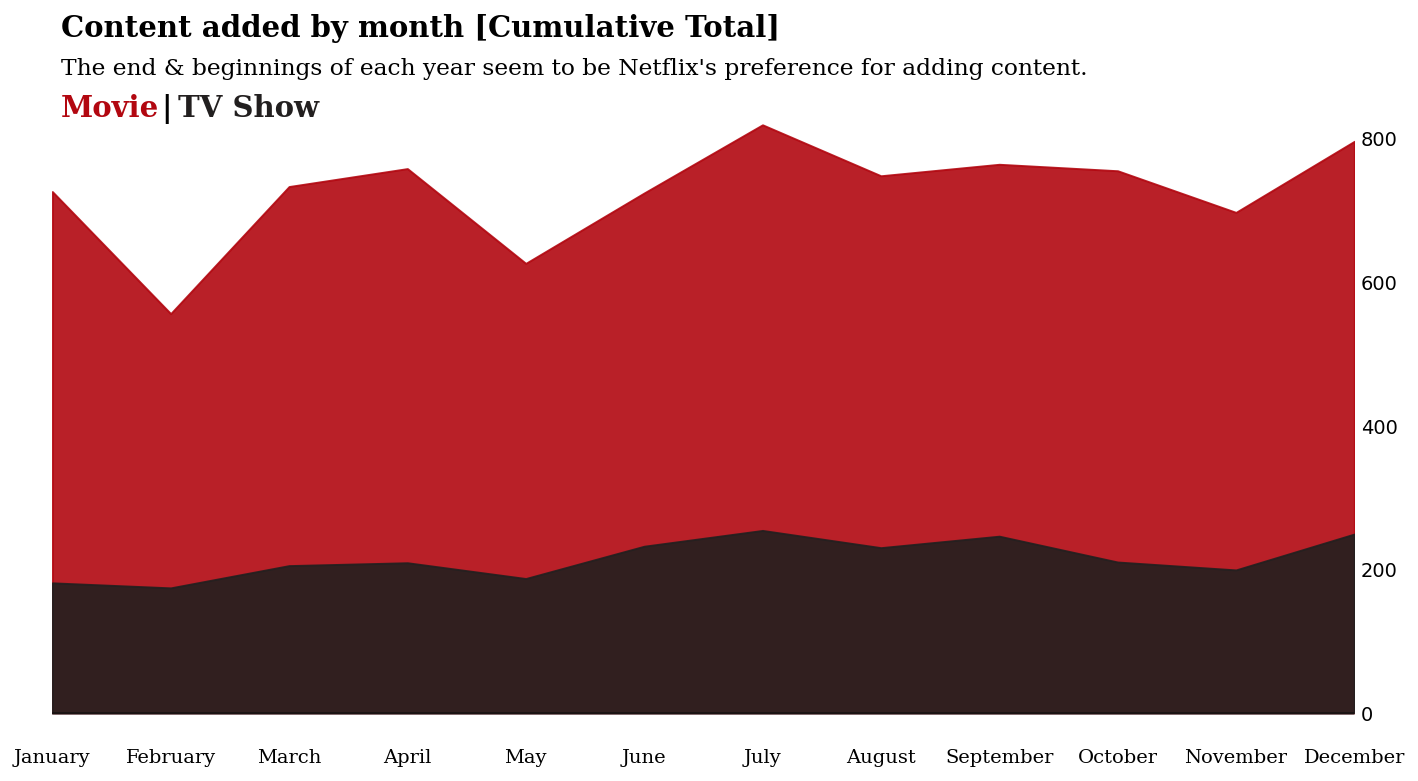

In [19]:
# Month-by-Month
month_order = ['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

df['month_name_added'] = pd.Categorical(df['month_name_added'], categories=month_order, ordered=True)

data_sub = df.groupby('type')['month_name_added'].value_counts().unstack().fillna(0).loc[['TV Show','Movie']].cumsum(axis=0).T

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ["#b20710", "#221f1f"]

for i, mtv in enumerate(df['type'].value_counts().index):
    mtv_rel = data_sub[mtv]
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], label=mtv,alpha=0.9)



ax.yaxis.tick_right()

ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .4)

#ax.set_ylim(0, 50)
#ax.legend(loc='upper left')
for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.grid(False)
ax.set_xticklabels(data_sub.index, fontfamily='serif', rotation=0)
ax.margins(x=0) # remove white spaces next to margins

#ax.set_xlim(2008,2020)
#plt.xticks(np.arange(2008, 2021, 1))

fig.text(0.13, 0.95, 'Content added by month [Cumulative Total]', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.905,
"The end & beginnings of each year seem to be Netflix's preference for adding content."

, fontsize=12, fontweight='light', fontfamily='serif')



fig.text(0.13,0.855,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19,0.855,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2,0.855,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')


ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

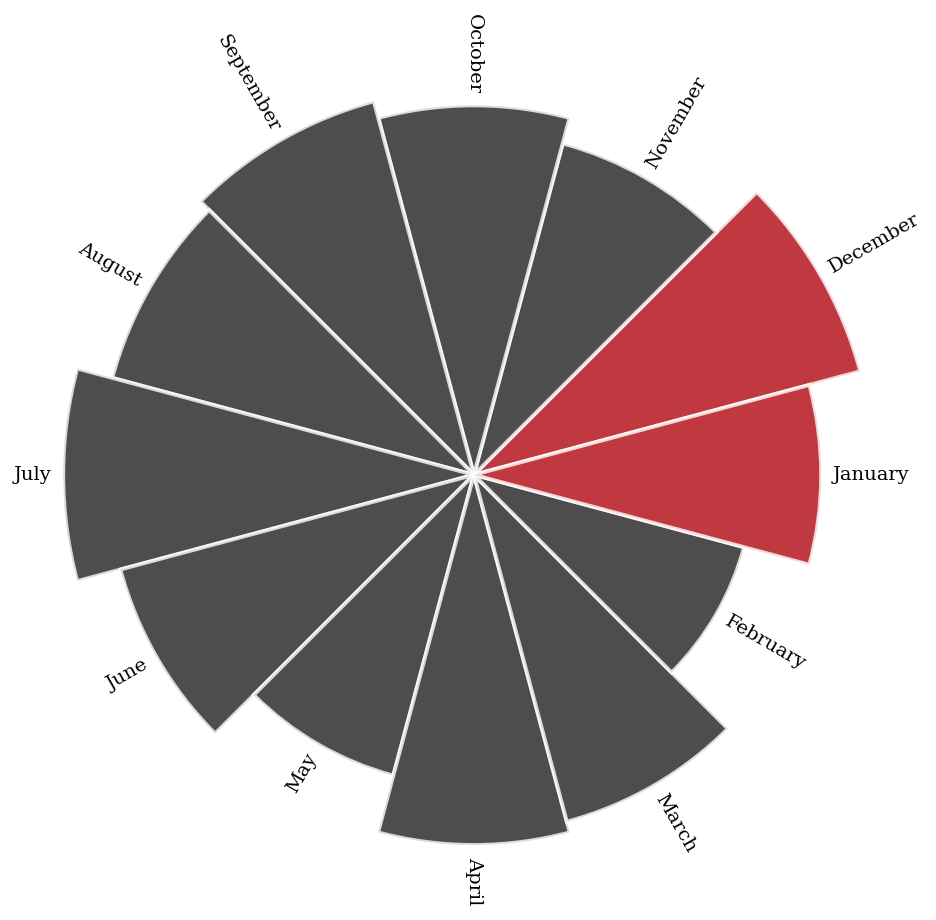

In [20]:
# Rotation plot
data_sub2 = data_sub

data_sub2['Value'] = data_sub2['Movie'] + data_sub2['TV Show']
data_sub2 = data_sub2.reset_index()

df_polar = data_sub2.sort_values(by='month_name_added',ascending=False)


color_map = ['#221f1f' for _ in range(12)]
color_map[0] = color_map[11] =  '#b20710' # color highlight


# initialize the figure
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 30
lowerLimit = 1
labelPadding = 30

# Compute max and min in the dataset
max = df_polar['Value'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df_polar.Value + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df_polar.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df_polar.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles,
    height=heights,
    width=width,
    bottom=lowerLimit,
    linewidth=2,
    edgecolor="white",
    color=color_map,alpha=0.8
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df_polar["month_name_added"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else:
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle,
        y=lowerLimit + bar.get_height() + labelPadding,
        s=label,
        ha=alignment, fontsize=10,fontfamily='serif',
        va='center',
        rotation=rotation,
        rotation_mode="anchor")


In [21]:
#@title Exploring Movies Genre

# Genres
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.colors


# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710','#f5f5f1'])

def genre_heatmap(df, title):
    df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(','))
    Types = []
    for i in df['genre']: Types += i
    Types = set(Types)
    print("There are {} types in the Netflix {} Dataset".format(len(Types),title))
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)
    corr = res.corr()
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10, 7))
    fig.text(.54,.88,'Genre correlation', fontfamily='serif',fontweight='bold',fontsize=15)
    fig.text(.75,.665,
            '''
             It is interesting that Independant Movies
             tend to be Dramas.

             Another observation is that
             Internatinal Movies are rarely
             in the Children's genre.
             ''', fontfamily='serif',fontsize=12,ha='right')
    pl = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, vmin=-.3, center=0, square=True, linewidths=2.5)

    plt.show()

There are 20 types in the Netflix Movie Dataset


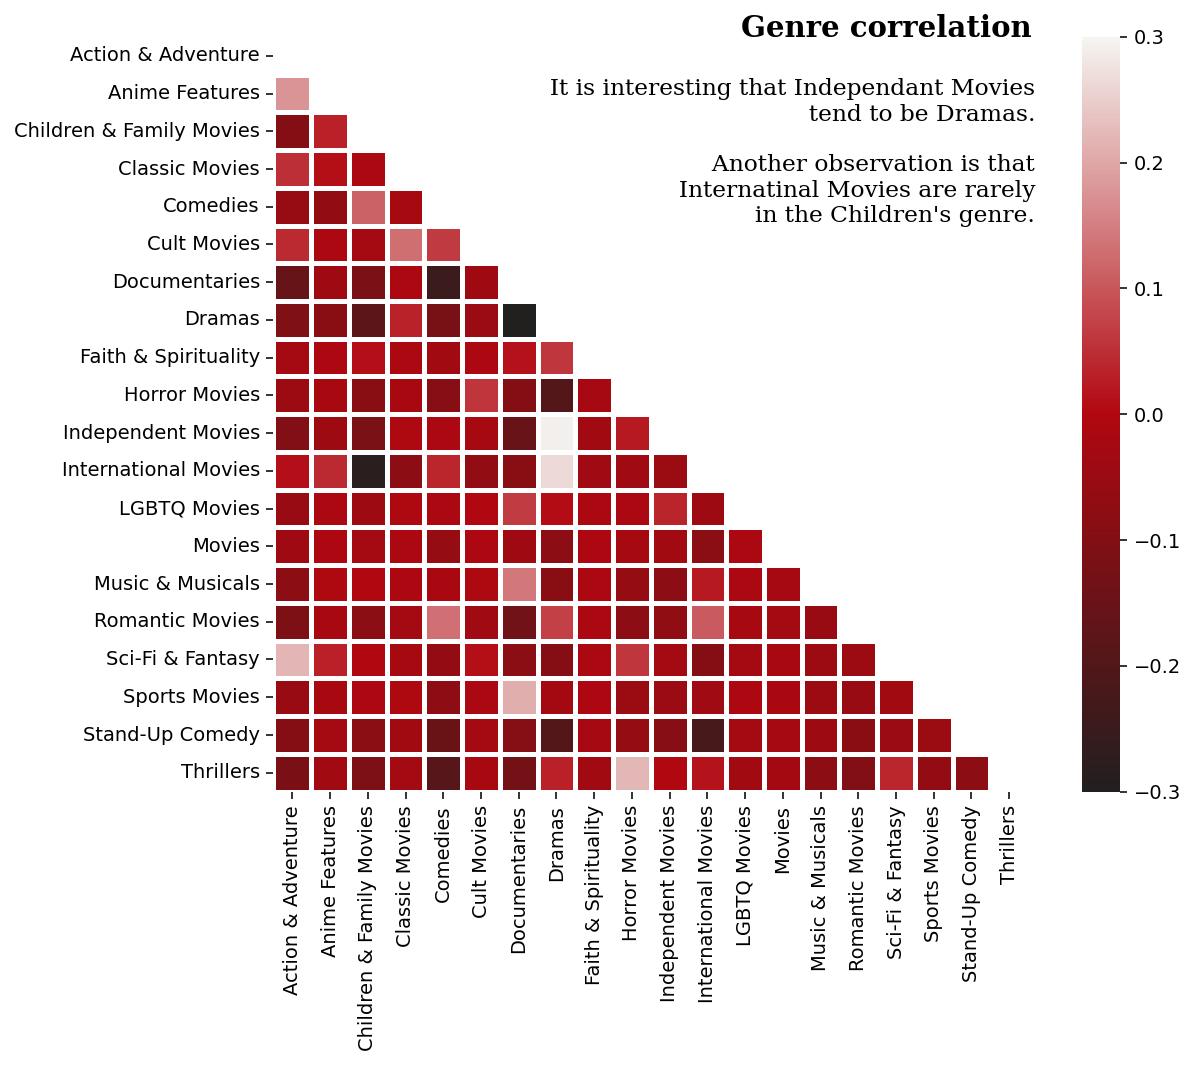

In [27]:
df_tv = df[df["type"] == "TV Show"]
df_movies = df[df["type"] == "Movie"]


genre_heatmap(df_movies, 'Movie')
plt.show()

In [23]:
data = df.groupby('first_country')[['count']].sum().sort_values(by='count', ascending=False).reset_index()[:10]
top_countries = data['first_country']

df_heatmap = df.loc[df['first_country'].isin(top_countries)]

df_heatmap = pd.crosstab(df_heatmap['first_country'], df_heatmap['target_ages'], normalize="index").T

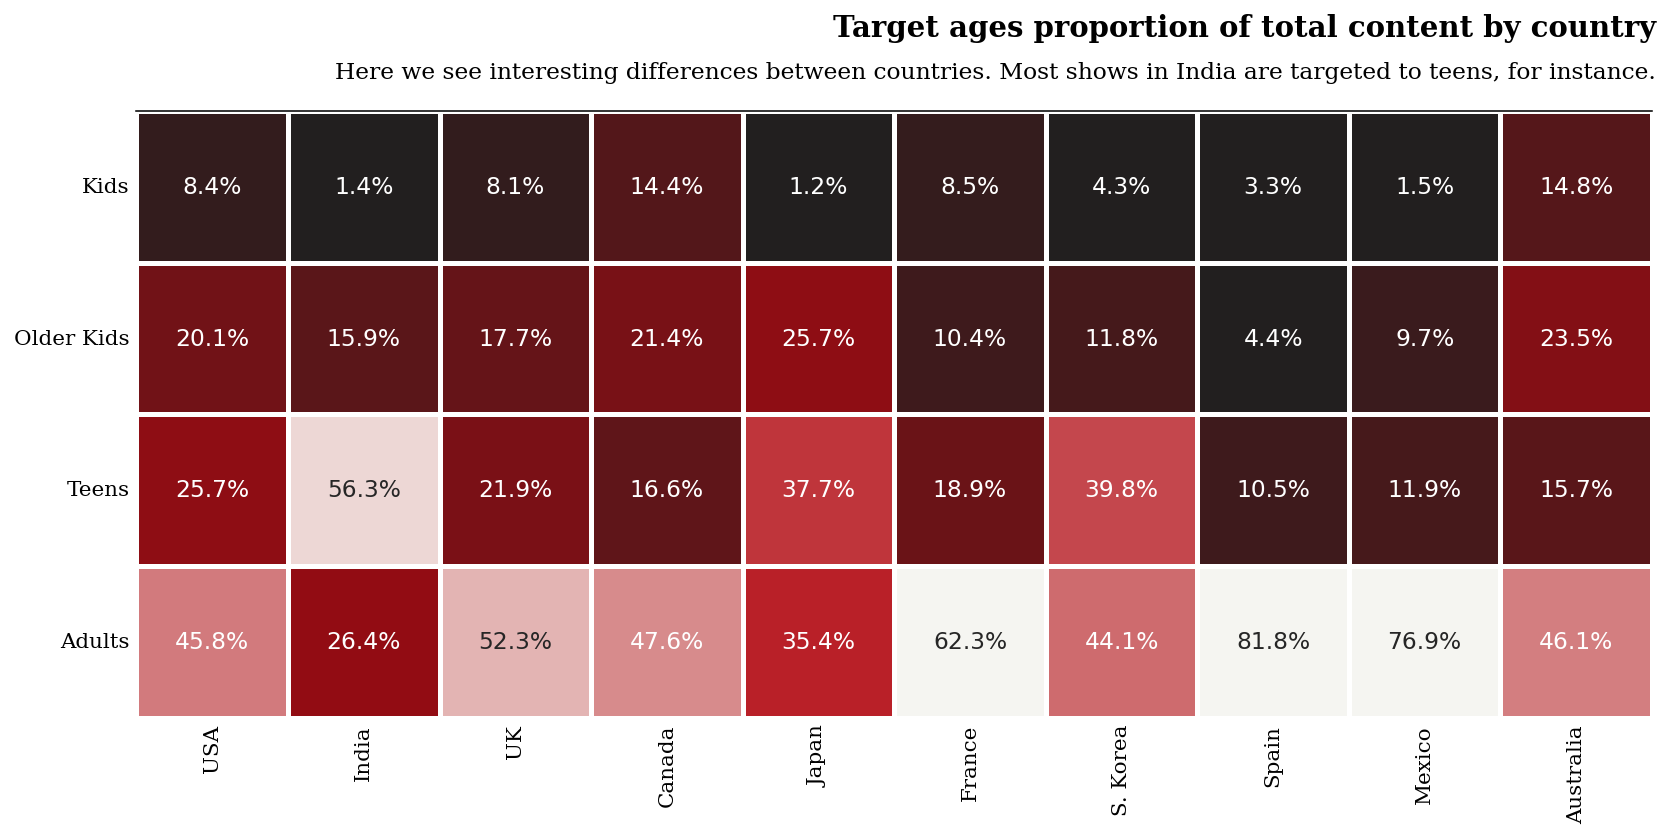

In [25]:
#@title Target Ages

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Use the top countries as the order
country_order2 = top_countries.tolist()

# Ensure age_order matches the available age groups in df_heatmap
age_order = ['Kids', 'Older Kids', 'Teens', 'Adults']

# Adjust the heatmap data to match the available countries and age groups
df_heatmap = df_heatmap.reindex(age_order).fillna(0)
df_heatmap = df_heatmap.reindex(columns=country_order2).fillna(0)

sns.heatmap(df_heatmap.loc[age_order, country_order2], cmap=cmap, square=True, linewidth=2.5, cbar=False,
            annot=True, fmt='.1%', vmax=.6, vmin=0.05, ax=ax, annot_kws={"fontsize":12})

ax.spines['top'].set_visible(True)

fig.text(.99, .725, 'Target ages proportion of total content by country', fontweight='bold', fontfamily='serif', fontsize=15, ha='right')
fig.text(0.99, 0.7, 'Here we see interesting differences between countries. Most shows in India are targeted to teens, for instance.', ha='right', fontsize=12, fontfamily='serif')

ax.set_yticklabels(ax.get_yticklabels(), fontfamily='serif', rotation=0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

ax.set_ylabel('')
ax.set_xlabel('')
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.tight_layout()

# Save the figure
fig.savefig('heatmap_plot.png', dpi=300)

# Show the plot
plt.show()

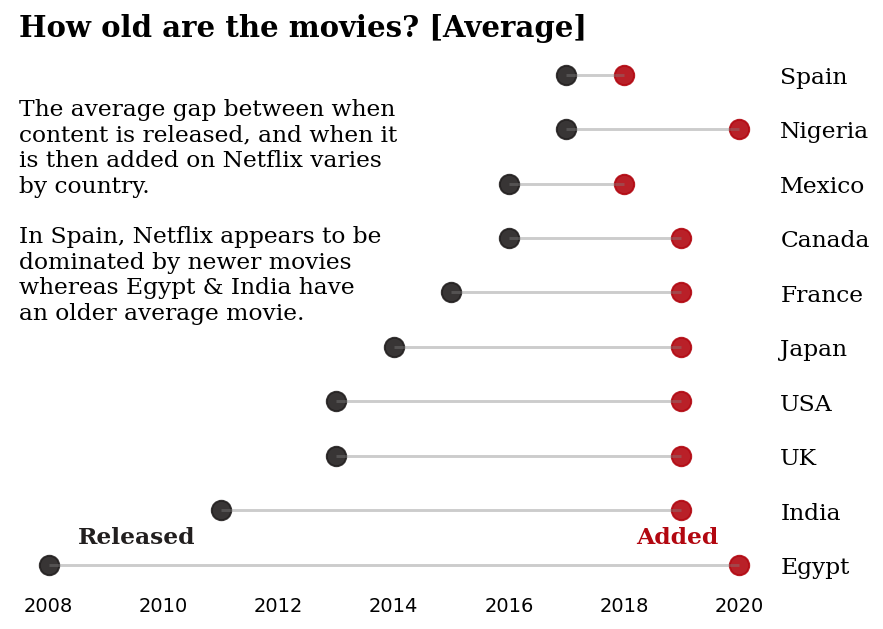

In [30]:
# Data

df_movies
df_tv

### Relevant groupings
data = df_movies.groupby('first_country')[['count']].sum().sort_values(by='count', ascending=False).reset_index()[:10]
top_countries = data['first_country']

df_loli = df_movies.loc[df_movies['first_country'].isin(top_countries)]

loli = df_loli.groupby('first_country')[['release_year', 'year_added']].mean().round()



# Reorder it following the values of the first value
ordered_df = loli.sort_values(by='release_year')

ordered_df_rev = loli.sort_values(by='release_year',ascending=False)

my_range=range(1,len(loli.index)+1)


fig, ax = plt.subplots(1, 1, figsize=(7, 5))

fig.text(0.13, 0.9, 'How old are the movies? [Average]', fontsize=15, fontweight='bold', fontfamily='serif')
plt.hlines(y=my_range, xmin=ordered_df['release_year'], xmax=ordered_df['year_added'], color='grey', alpha=0.4)
plt.scatter(ordered_df['release_year'], my_range, color='#221f1f',s=100, alpha=0.9, label='Average release date')
plt.scatter(ordered_df['year_added'], my_range, color='#b20710',s=100, alpha=0.9 , label='Average added date')
#plt.legend()

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)


# Removes the tick marks but keeps the labels
ax.tick_params(axis=u'both', which=u'both',length=0)
# Move Y axis to the right side
ax.yaxis.tick_right()

plt.yticks(my_range, ordered_df.index)
plt.yticks(fontname = "serif",fontsize=12)

# Custome legend
fig.text(0.19,0.175,"Released", fontweight="bold", fontfamily='serif', fontsize=12, color='#221f1f')
fig.text(0.76,0.175,"Added", fontweight="bold", fontfamily='serif', fontsize=12, color='#b20710')


fig.text(0.13, 0.46,
'''The average gap between when
content is released, and when it
is then added on Netflix varies
by country.

In Spain, Netflix appears to be
dominated by newer movies
whereas Egypt & India have
an older average movie.
'''

, fontsize=12, fontweight='light', fontfamily='serif')


#plt.xlabel('Year')
#plt.ylabel('Country')
plt.show()

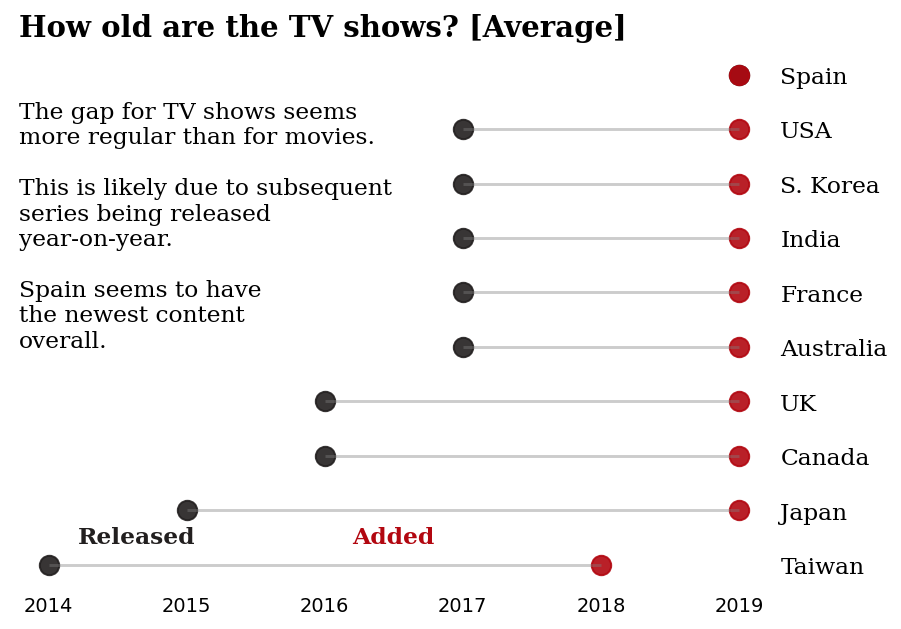

In [32]:
data = df_tv.groupby('first_country')[['count']].sum().sort_values(by='count', ascending=False).reset_index()[:10]
top_countries = data['first_country']

df_loli = df_tv.loc[df_tv['first_country'].isin(top_countries)]

loli = df_loli.groupby('first_country')[['release_year', 'year_added']].mean().round()

# Reorder it following the values of the first value:
ordered_df = loli.sort_values(by='release_year')

ordered_df_rev = loli.sort_values(by='release_year',ascending=False)

my_range=range(1,len(loli.index)+1)


fig, ax = plt.subplots(1, 1, figsize=(7, 5))

fig.text(0.13, 0.9, 'How old are the TV shows? [Average]', fontsize=15, fontweight='bold', fontfamily='serif')
plt.hlines(y=my_range, xmin=ordered_df['release_year'], xmax=ordered_df['year_added'], color='grey', alpha=0.4)
plt.scatter(ordered_df['release_year'], my_range, color='#221f1f',s=100, alpha=0.9, label='Average release date')
plt.scatter(ordered_df['year_added'], my_range, color='#b20710',s=100, alpha=0.9 , label='Average added date')
#plt.legend()

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

ax.yaxis.tick_right()
plt.yticks(my_range, ordered_df.index)
plt.yticks(fontname = "serif",fontsize=12)


fig.text(0.19,0.175,"Released", fontweight="bold", fontfamily='serif', fontsize=12, color='#221f1f')

fig.text(0.47,0.175,"Added", fontweight="bold", fontfamily='serif', fontsize=12, color='#b20710')


fig.text(0.13, 0.42,
'''The gap for TV shows seems
more regular than for movies.

This is likely due to subsequent
series being released
year-on-year.

Spain seems to have
the newest content
overall.
'''

, fontsize=12, fontweight='light', fontfamily='serif')


ax.tick_params(axis=u'both', which=u'both',length=0)
#plt.xlabel('Value of the variables')
#plt.ylabel('Group')
plt.show()

In [33]:
us_ind = df[(df['first_country'] == 'USA') | (df['first_country'] == 'India' )]

data_sub = df.groupby('first_country')['year_added'].value_counts().unstack().fillna(0).loc[['USA','India']].cumsum(axis=0).T

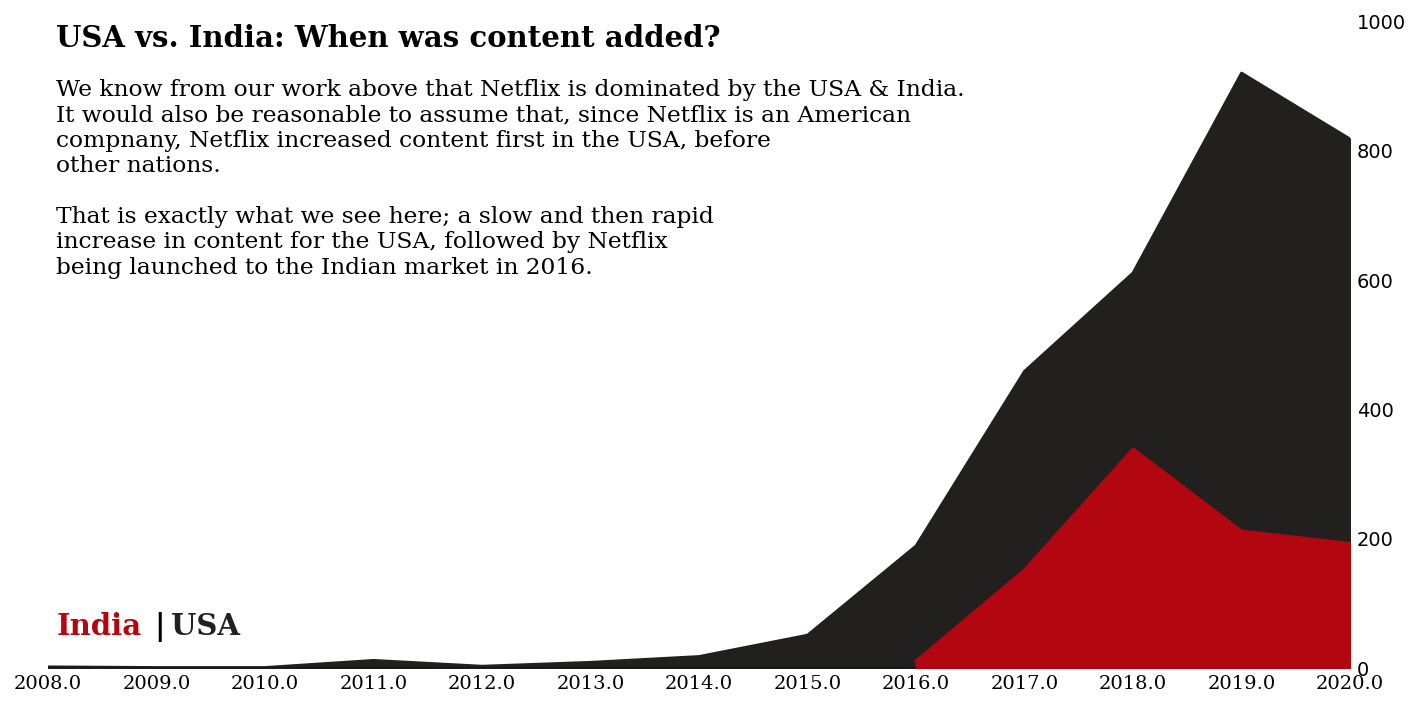

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ['#221f1f', '#b20710','#f5f5f1']

for i, hs in enumerate(us_ind['first_country'].value_counts().index):
    hs_built = us_ind[us_ind['first_country']==hs]['year_added'].value_counts().sort_index()
    ax.plot(hs_built.index, hs_built, color=color[i], label=hs)
    #ax.fill_between(hs_built.index, 0, hs_built, color=color[i], alpha=0.4)
    ax.fill_between(hs_built.index, 0, hs_built, color=color[i], label=hs)


ax.set_ylim(0, 1000)
#ax.legend(loc='upper left')
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

ax.yaxis.tick_right()

ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .4)

#ax.set_ylim(0, 50)
#ax.legend(loc='upper left')
for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.grid(False)
ax.set_xticklabels(data_sub.index, fontfamily='serif', rotation=0)
ax.margins(x=0) # remove white spaces next to margins

ax.set_xlim(2008,2020)
plt.xticks(np.arange(2008, 2021, 1))

fig.text(0.13, 0.85, 'USA vs. India: When was content added?', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.58,
'''
We know from our work above that Netflix is dominated by the USA & India.
It would also be reasonable to assume that, since Netflix is an American
compnany, Netflix increased content first in the USA, before
other nations.

That is exactly what we see here; a slow and then rapid
increase in content for the USA, followed by Netflix
being launched to the Indian market in 2016.'''

, fontsize=12, fontweight='light', fontfamily='serif')



fig.text(0.13,0.15,"India", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.188,0.15,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.198,0.15,"USA", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')


ax.tick_params(axis=u'both', which=u'both',length=0)


plt.show()

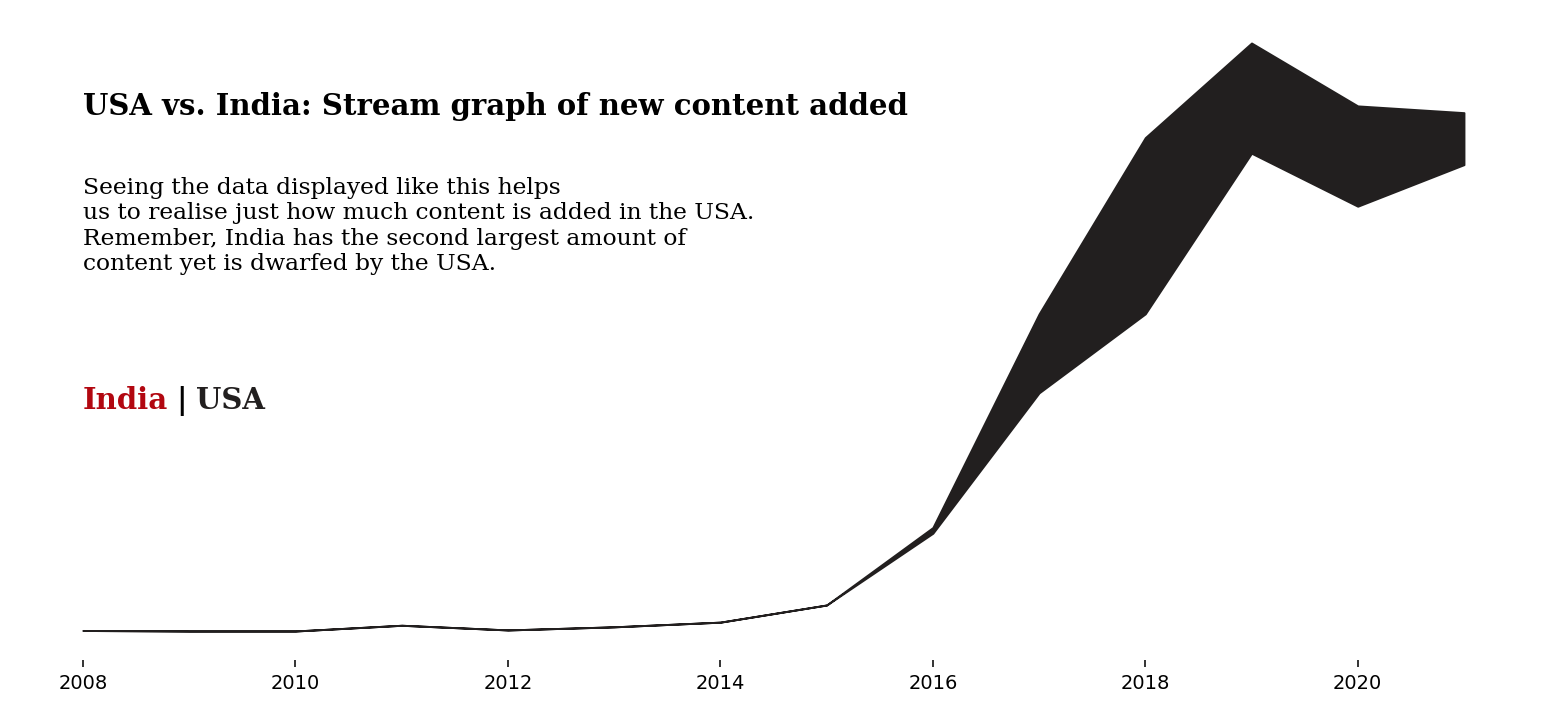

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
color = ['#b20710','#221f1f'][::-1]
hs_list = data_sub.columns
hs_built = data_sub[hs]

for i, hs in enumerate(hs_list):
    if i == 0 : continue
    ax.fill_between(hs_built.index, data_sub.iloc[:,i-1], data_sub.iloc[:,i], color=color[i-1])

for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_visible(False)
ax.set_axisbelow(True)
ax.set_yticks([])
#ax.legend(loc='upper left')
ax.grid(False)

fig.text(0.16, 0.76, 'USA vs. India: Stream graph of new content added', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.16, 0.575,
'''
Seeing the data displayed like this helps
us to realise just how much content is added in the USA.
Remember, India has the second largest amount of
content yet is dwarfed by the USA.'''

, fontsize=12, fontweight='light', fontfamily='serif')

fig.text(0.16,0.41,"India", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.208,0.41,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.218,0.41,"USA", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')


ax.tick_params(axis=u'y', which=u'both',length=0)

plt.show()

In [ ]:
!wget https://www.pngarts.com/files/1/Netflix-Logo-PNG-Transparent-Image.png -O netflix-icon-new.png

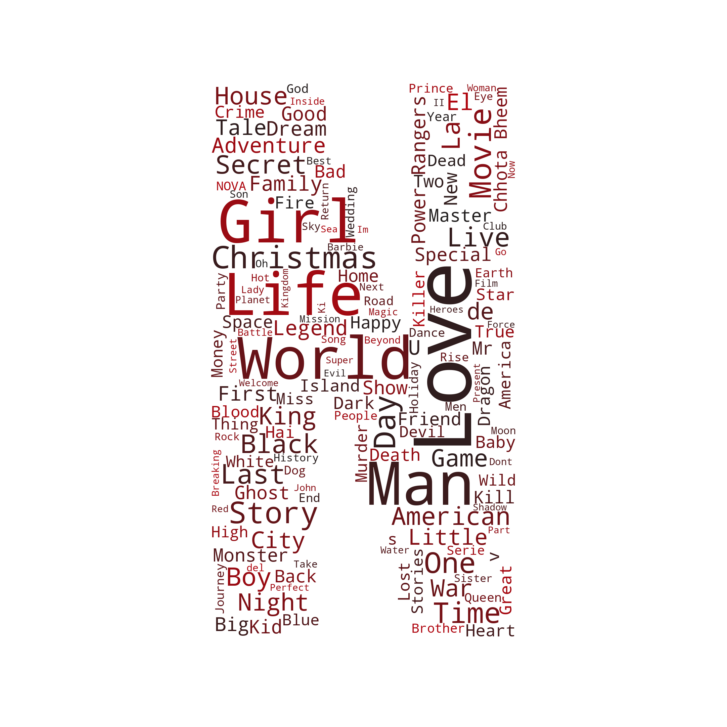

In [38]:
from wordcloud import WordCloud
import random
from PIL import Image
import matplotlib

# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710'])

text = str(list(df['title'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '')

mask = np.array(Image.open('/content/netflix-icon-new.png'))

wordcloud = WordCloud(background_color = 'white', width = 500,  height = 200,colormap=cmap, max_words = 150, mask = mask).generate(text)

plt.figure( figsize=(5,5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()